# Lomb-Scargle Periodogram

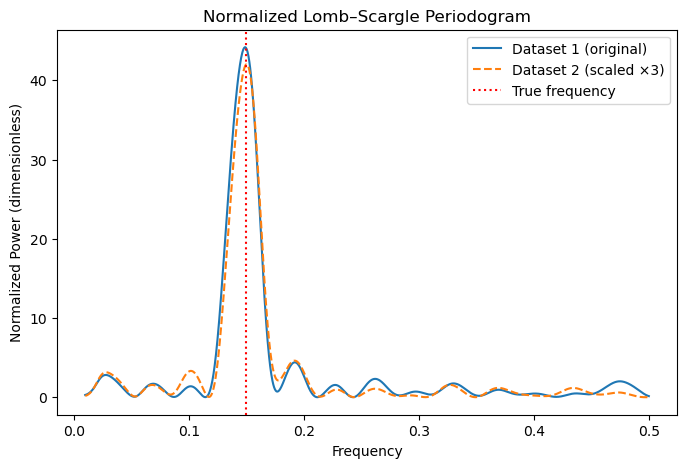

Power at true frequency (dataset 1): 44.04567874963595
Power at true frequency (dataset 2): 42.00366588419998


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Define Lomb-Scargle (classic Scargle 1982) power
# -----------------------------
def lomb_scargle_normalized(t, y, freqs):
    """
    Classic Lomb–Scargle power, normalized by variance of y.
    Output: dimensionless power.
    """
    y = np.asarray(y)
    y_demean = y - np.mean(y)         # remove mean
    var_y = np.var(y_demean, ddof=0)  # variance (units: y^2)

    P = []
    for f in freqs:
        w = 2 * np.pi * f  # angular frequency

        # tau shifts the phases to remove cross-terms
        tau = 0.5 * np.arctan2(
            np.sum(np.sin(2*w*t)),
            np.sum(np.cos(2*w*t))
        ) / w if w != 0 else 0.0

        cos_term = np.cos(w * (t - tau))
        sin_term = np.sin(w * (t - tau))

        A = np.sum(y_demean * cos_term)
        B = np.sum(y_demean * sin_term)

        # Numerators: A^2 and B^2 → units of y^2
        # Denominators: sums of cos^2/sin^2 → dimensionless
        # Then we divide by var_y (units: y^2), canceling the units
        P_omega = 0.5 * ((A**2 / np.sum(cos_term**2)) +
                         (B**2 / np.sum(sin_term**2))) / var_y
        P.append(P_omega)

    return np.array(P)


# -----------------------------
# Step 2: Generate two datasets with different scale
# -----------------------------
rng = np.random.default_rng(0)
N = 100
t = np.sort(rng.uniform(0, 30, size=N))   # uneven time sampling
true_freq = 0.15                          # signal frequency
signal = 2.0 * np.sin(2*np.pi*true_freq*t + 0.5)

# dataset 1: noise sigma = 0.5
y1 = signal + rng.normal(0, 0.5, size=N)

# dataset 2: scaled version (×3) → variance increases ×9
y2 = 3*signal + rng.normal(0, 1.5, size=N)

# -----------------------------
# Step 3: Compute periodograms
# -----------------------------
freqs = np.linspace(0.01, 0.5, 2000)
P1 = lomb_scargle_normalized(t, y1, freqs)
P2 = lomb_scargle_normalized(t, y2, freqs)

# -----------------------------
# Step 4: Plot and check
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(freqs, P1, label='Dataset 1 (original)')
plt.plot(freqs, P2, '--', label='Dataset 2 (scaled ×3)')
plt.axvline(true_freq, color='red', ls=':', label='True frequency')
plt.title("Normalized Lomb–Scargle Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Normalized Power (dimensionless)")
plt.legend()
plt.show()

# Print power at the true frequency for both datasets
idx = np.argmin(np.abs(freqs - true_freq))
print("Power at true frequency (dataset 1):", P1[idx])
print("Power at true frequency (dataset 2):", P2[idx])


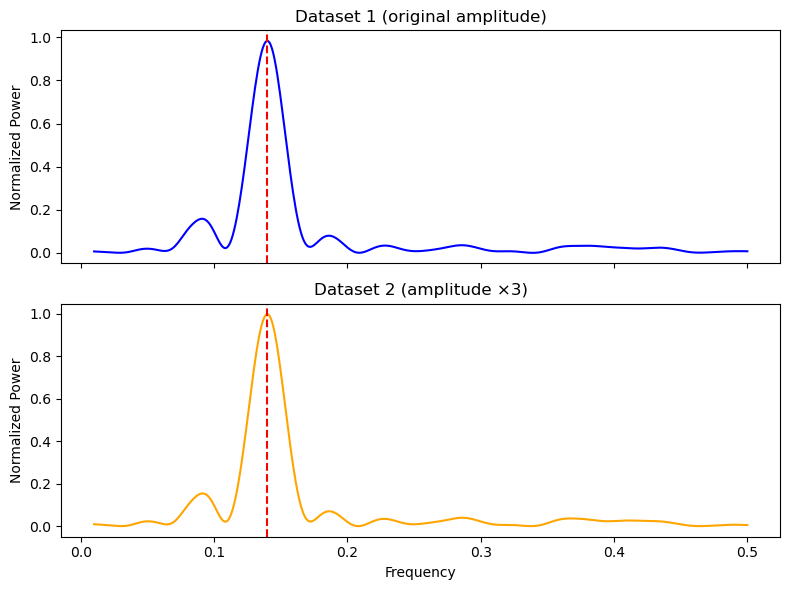

In [2]:
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import numpy as np

# Example synthetic data (same as before)
np.random.seed(42)
t = np.sort(np.random.uniform(0, 30, 100))   # irregular sampling
freq_true = 0.14
signal = np.sin(2 * np.pi * freq_true * t)
y1 = signal + 0.1 * np.random.randn(len(t))       # dataset 1
y2 = 3 * signal + 0.1 * np.random.randn(len(t))   # dataset 2 (scaled ×3)

# Frequencies for LS
frequency = np.linspace(0.01, 0.5, 500)
power1 = LombScargle(t, y1).power(frequency, normalization="standard")
power2 = LombScargle(t, y2).power(frequency, normalization="standard")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axes[0].plot(frequency, power1, color="blue")
axes[0].axvline(freq_true, color="red", ls="--")
axes[0].set_title("Dataset 1 (original amplitude)")
axes[0].set_ylabel("Normalized Power")

axes[1].plot(frequency, power2, color="orange")
axes[1].axvline(freq_true, color="red", ls="--")
axes[1].set_title("Dataset 2 (amplitude ×3)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Normalized Power")

plt.tight_layout()
plt.show()


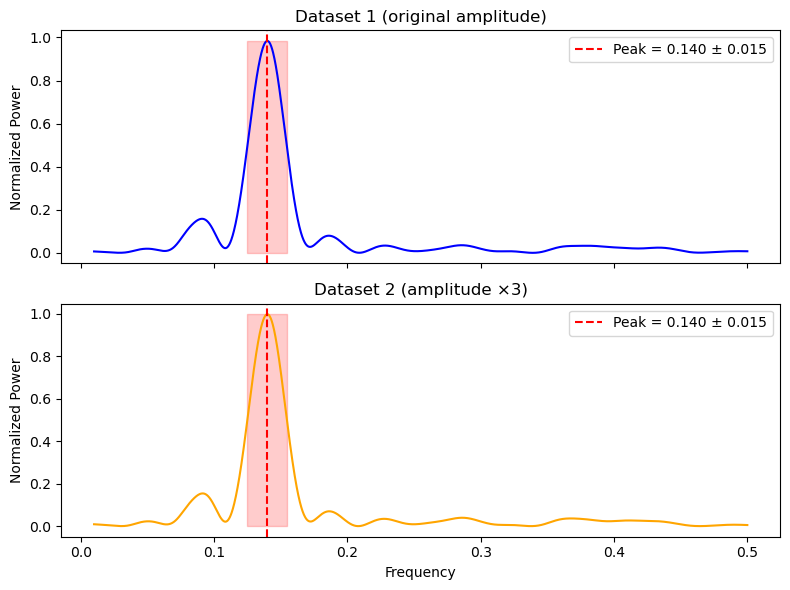

In [3]:
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import numpy as np

# Example synthetic data
np.random.seed(42)
t = np.sort(np.random.uniform(0, 30, 100))   # irregular sampling
freq_true = 0.14
signal = np.sin(2 * np.pi * freq_true * t)
y1 = signal + 0.1 * np.random.randn(len(t))       # dataset 1
y2 = 3 * signal + 0.1 * np.random.randn(len(t))   # dataset 2 (scaled ×3)

# Frequencies for LS
frequency = np.linspace(0.01, 0.5, 2000)
power1 = LombScargle(t, y1).power(frequency, normalization="standard")
power2 = LombScargle(t, y2).power(frequency, normalization="standard")

def find_freq_uncertainty(frequency, power):
    peak_idx = np.argmax(power)
    peak_freq = frequency[peak_idx]
    half_max = 0.5 * np.max(power)
    
    # Find nearest points on either side of peak where power falls below half
    left = frequency[np.where(power[:peak_idx] < half_max)[0]]
    right = frequency[peak_idx + np.where(power[peak_idx:] < half_max)[0]]
    
    if len(left) > 0 and len(right) > 0:
        fwhm = right[0] - left[-1]
        df = fwhm / 2
    else:
        df = np.nan
    return peak_freq, df

# Estimate uncertainties
f1, df1 = find_freq_uncertainty(frequency, power1)
f2, df2 = find_freq_uncertainty(frequency, power2)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Dataset 1
axes[0].plot(frequency, power1, color="blue")
axes[0].axvline(f1, color="red", ls="--", label=f"Peak = {f1:.3f} ± {df1:.3f}")
axes[0].fill_betweenx([0, np.max(power1)], f1 - df1, f1 + df1, color='red', alpha=0.2)
axes[0].set_title("Dataset 1 (original amplitude)")
axes[0].set_ylabel("Normalized Power")
axes[0].legend()

# Dataset 2
axes[1].plot(frequency, power2, color="orange")
axes[1].axvline(f2, color="red", ls="--", label=f"Peak = {f2:.3f} ± {df2:.3f}")
axes[1].fill_betweenx([0, np.max(power2)], f2 - df2, f2 + df2, color='red', alpha=0.2)
axes[1].set_title("Dataset 2 (amplitude ×3)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Normalized Power")
axes[1].legend()

plt.tight_layout()
plt.show()
